In [5]:
from msfnet_model import MSFNet

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

msf_net = MSFNet(in_ch=1, base=32)
msf_net.load_state_dict(torch.load("msfnet_best.pth", map_location=DEVICE))
msf_net.to(DEVICE)
msf_net.eval()

print("✅ MSF-Net loaded successfully")


✅ MSF-Net loaded successfully


In [ ]:
import os
import cv2
import torch
import numpy as np
from tqdm import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# -------- PATHS --------
BASE_DIR = r"/Users/manii/Desktop/RetinaGrader/APTOS"   # your folder
IMAGE_DIR = os.path.join(BASE_DIR, "train_images")
SAVE_DIR = os.path.join(BASE_DIR, "vessel_masks")

os.makedirs(SAVE_DIR, exist_ok=True)

# -------- Load MSF-Net --------
msf_net.load_state_dict(torch.load("msfnet_best.pth", map_location=DEVICE))
msf_net.to(DEVICE)
msf_net.eval()

print("MSF-Net loaded successfully")

# -------- Preprocess for segmentation --------
def preprocess_for_seg(img):
    original_shape = img.shape[:2]

    # Use green channel
    green = img[:, :, 1]

    # Resize to 512×512
    resized = cv2.resize(green, (512, 512))
    resized = resized.astype(np.float32) / 255.0

    tensor = torch.tensor(resized).unsqueeze(0).unsqueeze(0).to(DEVICE)

    return tensor, original_shape

# -------- Generate masks --------
image_files = [f for f in os.listdir(IMAGE_DIR) if f.endswith(".png")]

print("Total APTOS training images:", len(image_files))

with torch.no_grad():
    for img_name in tqdm(image_files):

        img_path = os.path.join(IMAGE_DIR, img_name)
        image = cv2.imread(img_path)

        if image is None:
            continue

        input_tensor, original_shape = preprocess_for_seg(image)

        prob_map = torch.sigmoid(msf_net(input_tensor))[0,0].cpu().numpy()

        # Resize back to original size
        prob_map = cv2.resize(prob_map, (original_shape[1], original_shape[0]))

        # Save grayscale probability map
        mask = (prob_map * 255).astype(np.uint8)

        save_path = os.path.join(SAVE_DIR, img_name)
        cv2.imwrite(save_path, mask)

print("✅ Vessel masks generated for APTOS train set")


MSF-Net loaded successfully
Total APTOS training images: 3662


100%|██████████| 3662/3662 [32:03<00:00,  1.90it/s]

✅ Vessel masks generated for APTOS train set


In [8]:
!pip install scikit-image scipy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 11.0 MB/s  0:00:01eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [scikit-image] [scikit-image]

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.morphology import skeletonize
from scipy.ndimage import convolve
from tqdm import tqdm

BASE_DIR = r"/Users/manii/Desktop/RetinaGrader/APTOS"
MASK_DIR = os.path.join(BASE_DIR, "vessel_masks")
CSV_PATH = os.path.join(BASE_DIR, "train.csv")
SAVE_CSV = os.path.join(BASE_DIR, "vessel_features.csv")

# Load APTOS labels
labels_df = pd.read_csv(CSV_PATH)

features = []

def compute_tortuosity(skel):
    coords = np.column_stack(np.where(skel))
    if len(coords) < 2:
        return 0
    dists = np.sqrt(np.sum(np.diff(coords, axis=0)**2, axis=1))
    total_length = np.sum(dists)
    straight_dist = np.linalg.norm(coords[0] - coords[-1])
    if straight_dist == 0:
        return 0
    return total_length / straight_dist

def count_branchpoints(skel):
    kernel = np.array([[1,1,1],
                       [1,10,1],
                       [1,1,1]])
    filtered = convolve(skel.astype(int), kernel)
    return np.sum(filtered >= 13)

print("Extracting vessel features...")

for _, row in tqdm(labels_df.iterrows(), total=len(labels_df)):
    img_id = row["id_code"]
    label = row["diagnosis"]

    mask_path = os.path.join(MASK_DIR, img_id + ".png")
    if not os.path.exists(mask_path):
        continue

    mask = cv2.imread(mask_path, 0)
    mask = (mask > 127).astype(np.uint8)

    vessel_area = np.sum(mask)
    total_area = mask.shape[0] * mask.shape[1]
    vessel_density = vessel_area / total_area

    skel = skeletonize(mask).astype(np.uint8)
    skeleton_length = np.sum(skel)

    tortuosity = compute_tortuosity(skel)
    branch_points = count_branchpoints(skel)

    features.append([
        img_id,
        label,
        vessel_density,
        skeleton_length,
        tortuosity,
        branch_points
    ])

feature_df = pd.DataFrame(features, columns=[
    "id_code",
    "diagnosis",
    "vessel_density",
    "skeleton_length",
    "tortuosity",
    "branch_points"
])

feature_df.to_csv(SAVE_CSV, index=False)

print("✅ Vessel features saved:", SAVE_CSV)


Extracting vessel features...


100%|██████████| 3662/3662 [07:02<00:00,  8.67it/s]

✅ Vessel features saved: /Users/manii/Desktop/acv_internal_project/APTOS/vessel_features.csv


In [10]:
!pip install timm



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
import os
import torch
import timm
import numpy as np
import pandas as pd
from tqdm import tqdm
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

print("Using device:", DEVICE)


# -----------------------
# PATHS
# -----------------------
BASE_DIR = "/Users/manii/Desktop/RetinaGrader/APTOS"
CSV_PATH = os.path.join(BASE_DIR, "train.csv")
IMG_DIR = os.path.join(BASE_DIR, "train_images")

# -----------------------
# LOAD CSV
# -----------------------
df = pd.read_csv(CSV_PATH)

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["diagnosis"],
    random_state=42
)

print("Train:", len(train_df), "Validation:", len(val_df))

# -----------------------
# TRANSFORMS (B3 prefers 300x300)
# -----------------------
train_transform = transforms.Compose([
    transforms.Resize((300,300)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

val_transform = transforms.Compose([
    transforms.Resize((300,300)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# -----------------------
# DATASET
# -----------------------
class APTOSDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform):
        self.df = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_name = self.df.loc[idx, "id_code"] + ".png"
        label = self.df.loc[idx, "diagnosis"]
        img_path = os.path.join(self.img_dir, img_name)
        
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long)

train_dataset = APTOSDataset(train_df, IMG_DIR, train_transform)
val_dataset = APTOSDataset(val_df, IMG_DIR, val_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0)

# -----------------------
# CLASS WEIGHTS (IMPORTANT)
# -----------------------
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_df["diagnosis"]),
    y=train_df["diagnosis"]
)

class_weights = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: mps
Train: 2929 Validation: 733


In [ ]:
# ============================================
# STAGE 3.3 — EfficientNet-B3 DR Classifier
# ============================================

import os
import torch
import timm
import numpy as np
import pandas as pd
from tqdm import tqdm
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

print("Using device:", DEVICE)


# -----------------------
# PATHS
# -----------------------
BASE_DIR = "/Users/manii/Desktop/RetinaGrader/APTOS"
CSV_PATH = os.path.join(BASE_DIR, "train.csv")
IMG_DIR = os.path.join(BASE_DIR, "train_images")

# -----------------------
# LOAD CSV
# -----------------------
df = pd.read_csv(CSV_PATH)

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["diagnosis"],
    random_state=42
)

print("Train:", len(train_df), "Validation:", len(val_df))

# -----------------------
# TRANSFORMS (B3 prefers 300x300)
# -----------------------
train_transform = transforms.Compose([
    transforms.Resize((300,300)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

val_transform = transforms.Compose([
    transforms.Resize((300,300)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# -----------------------
# DATASET
# -----------------------
class APTOSDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform):
        self.df = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_name = self.df.loc[idx, "id_code"] + ".png"
        label = self.df.loc[idx, "diagnosis"]
        img_path = os.path.join(self.img_dir, img_name)
        
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long)

train_dataset = APTOSDataset(train_df, IMG_DIR, train_transform)
val_dataset = APTOSDataset(val_df, IMG_DIR, val_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0)

# -----------------------
# CLASS WEIGHTS (IMPORTANT)
# -----------------------
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_df["diagnosis"]),
    y=train_df["diagnosis"]
)

class_weights = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)

# -----------------------
# MODEL — EfficientNet-B3
# -----------------------
model = timm.create_model(
    "efficientnet_b3",
    pretrained=True,
    num_classes=5
).to(DEVICE)

# -----------------------
# LOSS + OPTIMIZER
# -----------------------
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=50
)

# -----------------------
# TRAINING LOOP
# -----------------------
EPOCHS = 45
best_val_acc = 0

for epoch in range(1, EPOCHS+1):
    
    # ---- TRAIN ----
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch} - Training"):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    train_acc = 100 * correct / total
    
    # ---- VALIDATION ----
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc=f"Epoch {epoch} - Validation"):
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    val_acc = 100 * correct / total
    
    scheduler.step()
    
    print(f"\nEpoch {epoch}/{EPOCHS}")
    print(f"Train Loss: {train_loss/len(train_loader):.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val   Loss: {val_loss/len(val_loader):.4f} | Val Acc: {val_acc:.2f}%")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "efficientnet_b3_best.pth")
        print("✅ Best model saved!")

print("\n🎯 Training Complete!")
print("Best Validation Accuracy:", best_val_acc)


Using device: mps
Train: 2929 Validation: 733


Epoch 1 - Validation: 100%|██████████| 92/92 [00:45<00:00,  2.04it/s]



Epoch 1/45
Train Loss: 1.4320 | Train Acc: 63.40%
Val   Loss: 1.1454 | Val Acc: 67.12%
✅ Best model saved!


Epoch 2 - Validation: 100%|██████████| 92/92 [00:49<00:00,  1.85it/s]



Epoch 2/45
Train Loss: 0.8364 | Train Acc: 75.79%
Val   Loss: 1.0402 | Val Acc: 73.40%
✅ Best model saved!


Epoch 3 - Validation: 100%|██████████| 92/92 [00:43<00:00,  2.11it/s]



Epoch 3/45
Train Loss: 0.7023 | Train Acc: 79.99%
Val   Loss: 0.8654 | Val Acc: 76.26%
✅ Best model saved!


Epoch 4 - Validation: 100%|██████████| 92/92 [00:43<00:00,  2.11it/s]



Epoch 4/45
Train Loss: 0.5838 | Train Acc: 83.44%
Val   Loss: 0.9559 | Val Acc: 78.58%
✅ Best model saved!


Epoch 5 - Validation: 100%|██████████| 92/92 [00:48<00:00,  1.91it/s]



Epoch 5/45
Train Loss: 0.4751 | Train Acc: 86.45%
Val   Loss: 0.9274 | Val Acc: 75.58%


Epoch 6 - Validation: 100%|██████████| 92/92 [00:43<00:00,  2.12it/s]



Epoch 6/45
Train Loss: 0.4122 | Train Acc: 88.22%
Val   Loss: 0.9559 | Val Acc: 81.31%
✅ Best model saved!


Epoch 7 - Validation: 100%|██████████| 92/92 [00:44<00:00,  2.09it/s]



Epoch 7/45
Train Loss: 0.3911 | Train Acc: 89.07%
Val   Loss: 1.0355 | Val Acc: 77.90%


Epoch 8 - Validation: 100%|██████████| 92/92 [00:44<00:00,  2.09it/s]



Epoch 8/45
Train Loss: 0.3138 | Train Acc: 90.54%
Val   Loss: 1.0267 | Val Acc: 78.17%


Epoch 9 - Validation: 100%|██████████| 92/92 [00:43<00:00,  2.10it/s]



Epoch 9/45
Train Loss: 0.2478 | Train Acc: 93.55%
Val   Loss: 1.0287 | Val Acc: 78.17%


Epoch 10 - Validation: 100%|██████████| 92/92 [00:43<00:00,  2.10it/s]



Epoch 10/45
Train Loss: 0.2267 | Train Acc: 93.89%
Val   Loss: 1.1580 | Val Acc: 80.76%


Epoch 11 - Validation: 100%|██████████| 92/92 [00:43<00:00,  2.10it/s]



Epoch 11/45
Train Loss: 0.2407 | Train Acc: 93.82%
Val   Loss: 1.1328 | Val Acc: 81.58%
✅ Best model saved!


Epoch 12 - Validation: 100%|██████████| 92/92 [01:10<00:00,  1.31it/s]



Epoch 12/45
Train Loss: 0.1937 | Train Acc: 94.81%
Val   Loss: 1.1098 | Val Acc: 79.40%


Epoch 13 - Validation: 100%|██████████| 92/92 [01:09<00:00,  1.32it/s]



Epoch 13/45
Train Loss: 0.1758 | Train Acc: 95.60%
Val   Loss: 1.1868 | Val Acc: 79.54%


Epoch 14 - Validation: 100%|██████████| 92/92 [01:09<00:00,  1.32it/s]



Epoch 14/45
Train Loss: 0.1662 | Train Acc: 95.66%
Val   Loss: 1.1593 | Val Acc: 80.76%


Epoch 15 - Validation: 100%|██████████| 92/92 [01:10<00:00,  1.31it/s]



Epoch 15/45
Train Loss: 0.1613 | Train Acc: 96.31%
Val   Loss: 1.0804 | Val Acc: 80.08%


Epoch 16 - Validation: 100%|██████████| 92/92 [01:10<00:00,  1.31it/s]



Epoch 16/45
Train Loss: 0.1397 | Train Acc: 96.89%
Val   Loss: 1.1855 | Val Acc: 81.58%


Epoch 17 - Validation: 100%|██████████| 92/92 [01:09<00:00,  1.32it/s]



Epoch 17/45
Train Loss: 0.1379 | Train Acc: 96.38%
Val   Loss: 1.1891 | Val Acc: 78.31%


Epoch 18 - Validation: 100%|██████████| 92/92 [01:09<00:00,  1.31it/s]



Epoch 18/45
Train Loss: 0.1218 | Train Acc: 96.89%
Val   Loss: 1.3778 | Val Acc: 81.45%


Epoch 19 - Validation: 100%|██████████| 92/92 [01:09<00:00,  1.32it/s]



Epoch 19/45
Train Loss: 0.1235 | Train Acc: 96.93%
Val   Loss: 1.2577 | Val Acc: 80.35%


Epoch 20 - Validation: 100%|██████████| 92/92 [01:10<00:00,  1.31it/s]



Epoch 20/45
Train Loss: 0.0990 | Train Acc: 97.61%
Val   Loss: 1.4355 | Val Acc: 82.13%
✅ Best model saved!


Epoch 21 - Validation: 100%|██████████| 92/92 [01:10<00:00,  1.31it/s]



Epoch 21/45
Train Loss: 0.1040 | Train Acc: 97.34%
Val   Loss: 1.4062 | Val Acc: 82.54%
✅ Best model saved!


Epoch 22 - Validation: 100%|██████████| 92/92 [01:10<00:00,  1.31it/s]



Epoch 22/45
Train Loss: 0.0822 | Train Acc: 97.64%
Val   Loss: 1.5108 | Val Acc: 81.17%


Epoch 23 - Validation: 100%|██████████| 92/92 [01:10<00:00,  1.31it/s]



Epoch 23/45
Train Loss: 0.0743 | Train Acc: 98.26%
Val   Loss: 1.3232 | Val Acc: 80.63%


Epoch 24 - Validation: 100%|██████████| 92/92 [01:10<00:00,  1.31it/s]



Epoch 24/45
Train Loss: 0.0755 | Train Acc: 98.12%
Val   Loss: 1.5081 | Val Acc: 82.54%


Epoch 25 - Validation: 100%|██████████| 92/92 [01:09<00:00,  1.32it/s]



Epoch 25/45
Train Loss: 0.0646 | Train Acc: 98.16%
Val   Loss: 1.4907 | Val Acc: 81.99%


Epoch 26 - Validation: 100%|██████████| 92/92 [01:09<00:00,  1.32it/s]



Epoch 26/45
Train Loss: 0.0638 | Train Acc: 98.16%
Val   Loss: 1.5987 | Val Acc: 83.49%
✅ Best model saved!


Epoch 27 - Validation: 100%|██████████| 92/92 [01:09<00:00,  1.32it/s]



Epoch 27/45
Train Loss: 0.0679 | Train Acc: 98.16%
Val   Loss: 1.4950 | Val Acc: 81.58%


Epoch 28 - Validation: 100%|██████████| 92/92 [00:42<00:00,  2.14it/s]



Epoch 28/45
Train Loss: 0.0604 | Train Acc: 98.46%
Val   Loss: 1.6293 | Val Acc: 82.40%


Epoch 29 - Validation: 100%|██████████| 92/92 [00:43<00:00,  2.12it/s]



Epoch 29/45
Train Loss: 0.0530 | Train Acc: 98.53%
Val   Loss: 1.6017 | Val Acc: 82.54%


Epoch 30 - Validation: 100%|██████████| 92/92 [00:42<00:00,  2.15it/s]



Epoch 30/45
Train Loss: 0.0575 | Train Acc: 98.43%
Val   Loss: 1.5288 | Val Acc: 83.22%


Epoch 31 - Validation: 100%|██████████| 92/92 [00:43<00:00,  2.13it/s]



Epoch 31/45
Train Loss: 0.0489 | Train Acc: 98.91%
Val   Loss: 1.9879 | Val Acc: 83.08%


Epoch 32 - Validation: 100%|██████████| 92/92 [00:42<00:00,  2.15it/s]



Epoch 32/45
Train Loss: 0.0472 | Train Acc: 98.63%
Val   Loss: 1.3968 | Val Acc: 82.54%


Epoch 33 - Validation: 100%|██████████| 92/92 [00:43<00:00,  2.11it/s]



Epoch 33/45
Train Loss: 0.0518 | Train Acc: 98.43%
Val   Loss: 1.7307 | Val Acc: 82.26%


Epoch 34 - Validation: 100%|██████████| 92/92 [00:42<00:00,  2.15it/s]



Epoch 34/45
Train Loss: 0.0476 | Train Acc: 98.74%
Val   Loss: 1.5085 | Val Acc: 80.90%


Epoch 35 - Validation: 100%|██████████| 92/92 [00:43<00:00,  2.11it/s]



Epoch 35/45
Train Loss: 0.0633 | Train Acc: 98.87%
Val   Loss: 1.7614 | Val Acc: 82.67%


Epoch 36 - Validation: 100%|██████████| 92/92 [00:43<00:00,  2.13it/s]



Epoch 36/45
Train Loss: 0.0414 | Train Acc: 98.70%
Val   Loss: 1.6900 | Val Acc: 82.40%


Epoch 37 - Validation: 100%|██████████| 92/92 [00:50<00:00,  1.81it/s]



Epoch 37/45
Train Loss: 0.0346 | Train Acc: 98.84%
Val   Loss: 1.5978 | Val Acc: 81.86%


Epoch 38 - Validation: 100%|██████████| 92/92 [00:47<00:00,  1.95it/s]



Epoch 38/45
Train Loss: 0.0364 | Train Acc: 98.91%
Val   Loss: 1.7040 | Val Acc: 82.54%


Epoch 39 - Validation: 100%|██████████| 92/92 [01:02<00:00,  1.48it/s]



Epoch 39/45
Train Loss: 0.0416 | Train Acc: 98.87%
Val   Loss: 1.7130 | Val Acc: 82.40%


Epoch 40 - Validation: 100%|██████████| 92/92 [00:49<00:00,  1.85it/s]



Epoch 40/45
Train Loss: 0.0290 | Train Acc: 99.04%
Val   Loss: 2.0588 | Val Acc: 83.22%


Epoch 41 - Validation: 100%|██████████| 92/92 [00:51<00:00,  1.79it/s]



Epoch 41/45
Train Loss: 0.0328 | Train Acc: 98.98%
Val   Loss: 1.8949 | Val Acc: 83.49%


Epoch 42 - Validation: 100%|██████████| 92/92 [00:50<00:00,  1.83it/s]



Epoch 42/45
Train Loss: 0.0329 | Train Acc: 98.98%
Val   Loss: 1.8663 | Val Acc: 83.36%


Epoch 43 - Validation: 100%|██████████| 92/92 [00:54<00:00,  1.70it/s]



Epoch 43/45
Train Loss: 0.0350 | Train Acc: 98.94%
Val   Loss: 1.7469 | Val Acc: 82.40%


Epoch 44 - Validation: 100%|██████████| 92/92 [00:47<00:00,  1.93it/s]



Epoch 44/45
Train Loss: 0.0294 | Train Acc: 99.01%
Val   Loss: 2.0003 | Val Acc: 83.22%


Epoch 45 - Validation: 100%|██████████| 92/92 [00:48<00:00,  1.90it/s]


Epoch 45/45
Train Loss: 0.0417 | Train Acc: 98.87%
Val   Loss: 1.8522 | Val Acc: 82.67%

🎯 Training Complete!
Best Validation Accuracy: 83.4924965893588


Stage 3.4 : Evaluation 

In [2]:
import torch
import timm

if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

# Recreate model EXACTLY as training
model = timm.create_model(
    "efficientnet_b3",
    pretrained=False,   # IMPORTANT: False when loading weights
    num_classes=5
)

# Load saved weights
state_dict = torch.load("efficientnet_b3_best.pth", map_location=DEVICE)
model.load_state_dict(state_dict)

model.to(DEVICE)
model.eval()

print("✅ Model loaded successfully using timm")

✅ Model loaded successfully using timm


In [3]:
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in tqdm(val_loader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)

        preds = torch.argmax(probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

print("✅ Predictions collected")

100%|██████████| 92/92 [00:44<00:00,  2.08it/s]

✅ Predictions collected


In [7]:
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    cohen_kappa_score
)

import seaborn as sns
import matplotlib.pyplot as plt

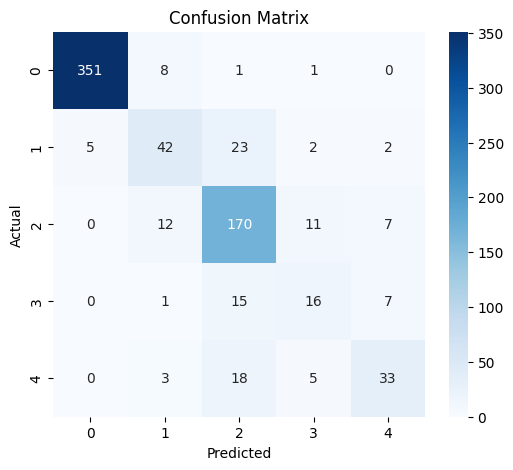

In [8]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[0,1,2,3,4],
            yticklabels=[0,1,2,3,4])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [9]:
print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds, digits=4))


📊 Classification Report:
              precision    recall  f1-score   support

           0     0.9860    0.9723    0.9791       361
           1     0.6364    0.5676    0.6000        74
           2     0.7489    0.8500    0.7963       200
           3     0.4571    0.4103    0.4324        39
           4     0.6735    0.5593    0.6111        59

    accuracy                         0.8349       733
   macro avg     0.7004    0.6719    0.6838       733
weighted avg     0.8327    0.8349    0.8322       733



In [10]:
kappa = cohen_kappa_score(all_labels, all_preds)
print(f"\n🧠 Cohen's Kappa Score: {kappa:.4f}")


🧠 Cohen's Kappa Score: 0.7496


In [11]:
auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')
print(f"\n📈 Multi-class ROC-AUC: {auc:.4f}")


📈 Multi-class ROC-AUC: 0.9366


STEP : 3.6.1

In [12]:
import torch
import timm

DEVICE = torch.device("mps" if torch.backends.mps.is_available()
                      else "cuda" if torch.cuda.is_available()
                      else "cpu")

model = timm.create_model(
    "efficientnet_b3",
    pretrained=False,
    num_classes=5
)

model.load_state_dict(
    torch.load("efficientnet_b3_best.pth", map_location=DEVICE)
)

model.to(DEVICE)
model.eval()

print("✅ EfficientNet-B3 loaded for inference")

✅ EfficientNet-B3 loaded for inference


In [13]:
target_layer = model.conv_head

In [14]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Forward hook
        target_layer.register_forward_hook(self.save_activation)
        
        # Full backward hook (NEW)
        target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate(self, input_tensor, class_idx=None):
        
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = torch.argmax(output)

        self.model.zero_grad()
        output[:, class_idx].backward()

        weights = torch.mean(self.gradients, dim=(2,3), keepdim=True)
        cam = torch.sum(weights * self.activations, dim=1)
        cam = torch.relu(cam)

        cam = cam.squeeze().detach().cpu().numpy()
        cam = cv2.resize(cam, (300,300))

        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

        return cam

In [15]:
grad_cam = GradCAM(model, model.conv_head)

In [16]:
# STEP 3.6.3 — Single Image Inference + Heatmap
from PIL import Image
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((300,300)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

def predict_with_gradcam(img_path):
    
    image = Image.open(img_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        outputs = model(input_tensor)
        probs = torch.softmax(outputs, dim=1)
        pred = torch.argmax(probs, dim=1).item()
        confidence = probs[0][pred].item()

    # GradCAM
    cam = grad_cam.generate(input_tensor, class_idx=pred)

    return pred, confidence, cam

In [17]:
def overlay_heatmap(img_path, cam):
    
    img = cv2.imread(img_path)
    img = cv2.resize(img, (300,300))

    heatmap = cv2.applyColorMap(
        np.uint8(255 * cam),
        cv2.COLORMAP_JET
    )

    overlay = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    return overlay

Predicted Class: 2
Confidence: 99.71 %


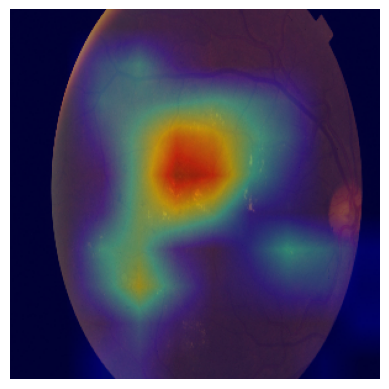

In [ ]:
import cv2
img_path = r"/Users/manii/Desktop/RetinaGrader/APTOS/train_images/000c1434d8d7.png"

pred, conf, cam = predict_with_gradcam(img_path)
overlay = overlay_heatmap(img_path, cam)

print("Predicted Class:", pred)
print("Confidence:", round(conf*100,2), "%")

import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

class_map = {
    0: "No DR",
    1: "Mild",
    2: "Moderate",
    3: "Severe",
    4: "Proliferative DR"
}